In [1]:
#importing required librairies
from __future__ import division
import os
import numpy as np
import random
import scipy.misc
from scipy import pi #to convert steering angles to radins
from itertools import islice
import matplotlib.pyplot as plt 
import tensorflow as tf
import scipy
from tensorflow.core.protobuf import saver_pb2
import driving_data
import model
import cv2
from subprocess import call
import math
from keras.models import Sequential 
from keras.layers import Dense, Activation 
# import the necessary packages
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras import backend as K
from prettytable import PrettyTable
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.preprocessing.image import img_to_array
from __future__ import division
from scipy.misc import imread, imresize
from itertools import islice
from keras.layers import  Input
from keras.layers.core import Dense, Flatten, Lambda, Activation, Dropout
from keras.models import Model
from keras.optimizers import SGD
import tensorflow as tf
from keras import backend as K

C:\Users\Gangadhar\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Checking the PDF of Steering Angle

Completed processing data.txt


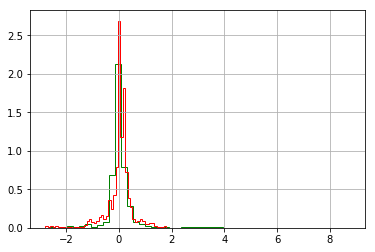

<Figure size 1080x720 with 0 Axes>

In [2]:
#importing data
DATA_FOLDER = './driving_dataset/'  #folde containing images and steering angle Data
TRAIN_FILE = os.path.join(DATA_FOLDER, 'data.txt') #getting the steering angle data

#spliting the data into 70-30 train and test data 
#first 70% as train and rest as test
split =0.7 #fraction spliting the train data

X = [] #Name of the images
y = [] #steering angle data
with open(TRAIN_FILE) as fp:
    for line in islice(fp,None):
        path, angle = line.strip().split()
        full_path = os.path.join(DATA_FOLDER, path)
        X.append(full_path)
        # converting angle from degrees to radians
        y.append(float(angle) * pi / 180 )


y = np.array(y) #getting the final steering angle data
print("Completed processing data.txt")

#spliting into train and test
split_index = int(len(y)*0.7) 
train_y = y[:split_index]
test_y = y[split_index:]


#PDF of train and test 'y' values. 
plt.hist(train_y, bins=50, density=1, color='green', histtype ='step');
plt.hist(test_y, bins=50, density=1, color='red', histtype ='step');
plt.grid(True)
plt.figure(figsize=(15,10))
plt.show()         

### Observations:
    * train and test ditributions are not fully-overlapping which indicates a difference in train and test data
    which is natural,as we split the data in temporal way and the driving conditions change over time.
    * Most of the steering angles are distributed around zero ,from which we can infer that the road is straight most of the times
    

## Building a base-line model without training on Images

In [3]:
#Model 0: Base line Model: y_test_pred = mean(y_train_i)
#here we are taking each predicted value of each data-point as just the mean of all the steering-angles in the data
train_mean_y = np.mean(train_y)
#computiing the MSE of base-model
print('Test_MSE(MEAN):%f' % np.mean(np.square(test_y-train_mean_y)) )

#As most of the steering angle distributed around zero ,let us see the MSE by taking all predicted values as Zero 
print('Test_MSE(ZERO):%f' % np.mean(np.square(test_y-0.0)) )


Test_MSE(MEAN):0.241561
Test_MSE(ZERO):0.241107


### Observations:
   * We know the Ideal MSE that we can get is Zero for a Regression problem.
   * By just using base-models like taking mean or taking the most occuring values of steering angles , we got MSE values close to Zero, which are pretty decent.
   * We have to get the MSE value less than 0.24 by training CNN model.
    

# Building end-to-end CNN model

In [4]:
#seperating the images and steering angles 
xs = [] #images data
ys = [] #steering angle data

#points to the end of the last batch , these are used while importing data batch-size which indicates the index at which
#previous batch stopped and starts a new batch from that index
train_batch_pointer = 0 
test_batch_pointer = 0

#read data.txt
with open("driving_dataset/data.txt") as f:
    for line in f:
        xs.append("driving_dataset/" + line.split()[0])
        #so the steering wheel angle in radians is used as the output
        ys.append(float(line.split()[1]) * scipy.pi / 180)

#get number of images
num_images = len(xs)
print("Number of images in the Data-set are: {}".format(num_images))

Number of images in the Data-set are: 45406


## Train-Test Split (70-30)

In [5]:
#splitting the data into 70-30 train and test ,here we take first 70% of the data as train and rest as test
train_xs = (xs[:int(len(xs) * 0.7)])
train_ys = (ys[:int(len(xs) * 0.7)])

#taking the rest 30% as test data
test_xs =(xs[-int(len(xs) * 0.3):])
test_ys = (ys[-int(len(xs) * 0.3):])

#getting the number of images in train and test data
num_train_images = len(train_xs)
num_test_images = len(test_xs)

print("Number of images in the train-data are: {}".format(num_train_images))
print("Number of images in the test-data are: {}".format(num_test_images))

Number of images in the train-data are: 31784
Number of images in the test-data are: 13621


In [6]:
#utility functions for loading data batch-wise
#batch_size will be given by us
def LoadTrainBatch(batch_size):
    global train_batch_pointer #we start from zero
    x_out = []
    y_out = []
    for i in range(0, batch_size):
        x_out.append(scipy.misc.imresize(scipy.misc.imread(train_xs[(train_batch_pointer + i) 
                                                                % num_train_images])[-150:], [66, 200]) / 255.0)
        #here we are taking last 150 rows of the image and normalizing the data by dividing by 255
        y_out.append([train_ys[(train_batch_pointer + i) % num_train_images]])
    train_batch_pointer += batch_size #start from where the previous batch left
    return x_out, y_out

def LoadValBatch(batch_size):
    global test_batch_pointer
    x_out = []
    y_out = []
    for i in range(0, batch_size):
        x_out.append(scipy.misc.imresize(scipy.misc.imread(test_xs[(test_batch_pointer + i)
                                                                  % num_test_images])[-150:], [66, 200]) / 255.0)
         #here we are taking last 150 rows of the image and normalizing the data by dividing by 255
        y_out.append([test_ys[(test_batch_pointer + i) % num_test_images]])
    test_batch_pointer += batch_size #start from where the previous batch left
    return x_out, y_out


## Building a 5-layered CNN and 3-fully connected Layers Network model for Training

In [7]:
#utility functions for weight and bias initializations for avoiding redefining every single time
#initilizing weights randomly with standard deviation of 0.1
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1) #this is not a normal normal distribution, we truncate the tails 
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

#utility function for kernel convolution
# x : the image
def conv2d(x, W, stride):
    return tf.nn.conv2d(x, W, strides=[1, stride, stride, 1], padding='VALID')

#defining the dimensions of the image input and steering angle
# x : None is batch_size , 66*200 :actual image size 3: RGB layers of the image
# y : we have batch size and corresponding steering angles
x = tf.placeholder(tf.float32, shape=[None, 66, 200, 3])
y_ = tf.placeholder(tf.float32, shape=[None, 1])

x_image = x #ranamimg x as x_image as input is image in our model

#first convolutional layer and their corresponding weights
W_conv1 = weight_variable([5, 5, 3, 24])  #kernel_size 5*5 
b_conv1 = bias_variable([24])

h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1, 2) + b_conv1) #2*2 striding

#second convolutional layer  and their corresponding weights
W_conv2 = weight_variable([5, 5, 24, 36])  #kernel_size 5*5 
b_conv2 = bias_variable([36])

h_conv2 = tf.nn.relu(conv2d(h_conv1, W_conv2, 2) + b_conv2) #2*2 striding


#third convolutional layer  and their corresponding weights
W_conv3 = weight_variable([5, 5, 36, 48]) #kernel_size 5*5 
b_conv3 = bias_variable([48])

h_conv3 = tf.nn.relu(conv2d(h_conv2, W_conv3, 2) + b_conv3) #2*2 striding

#fourth convolutional layer  and their corresponding weights
W_conv4 = weight_variable([3, 3, 48, 64]) #kernel_size 3*3 
b_conv4 = bias_variable([64])

h_conv4 = tf.nn.relu(conv2d(h_conv3, W_conv4, 1) + b_conv4) #no striding

#fifth convolutional layer  and their corresponding weights
W_conv5 = weight_variable([3, 3, 64, 64]) #kernel_size 3*3 
b_conv5 = bias_variable([64])

h_conv5 = tf.nn.relu(conv2d(h_conv4, W_conv5, 1) + b_conv5) #no striding

#flattening layers with 1164 neurons
#weight and bias initializations
W_fc1 = weight_variable([1152, 1164])
b_fc1 = bias_variable([1164])

h_conv5_flat = tf.reshape(h_conv5, [-1, 1152]) #flattenig
h_fc1 = tf.nn.relu(tf.matmul(h_conv5_flat, W_fc1) + b_fc1)

keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob) #dropout to avoid overfitting

#fully connected layer1 with 100 neurons
#weight and bias initializations
W_fc2 = weight_variable([1164, 100])
b_fc2 = bias_variable([100])

h_fc2 = tf.nn.relu(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)
h_fc2_drop = tf.nn.dropout(h_fc2, keep_prob) #dropout

#fully connected layer2 with 50 neurons
#weight and bias initializations
W_fc3 = weight_variable([100, 50])
b_fc3 = bias_variable([50])

h_fc3 = tf.nn.relu(tf.matmul(h_fc2_drop, W_fc3) + b_fc3)
h_fc3_drop = tf.nn.dropout(h_fc3, keep_prob) #dropout

#fully connected layer3 with 10 neurons
#weight and bias initializations
W_fc4 = weight_variable([50, 10])
b_fc4 = bias_variable([10])

h_fc4 = tf.nn.relu(tf.matmul(h_fc3_drop, W_fc4) + b_fc4)
h_fc4_drop = tf.nn.dropout(h_fc4, keep_prob) #dropout

#Output layer which gives the steering angle in radians
#weight and bias initializations
W_fc5 = weight_variable([10, 1])
b_fc5 = bias_variable([1])

y = (tf.matmul(h_fc4_drop, W_fc5) + b_fc5)#using linear for the final-output


## Training Model with CNN Network 

In [8]:
#creating a folder to save the trained model
LOGDIR = './save'

#initializing the tensorfloe session
sess = tf.InteractiveSession()

#regularization parameter for loss funcation
L2NormConst = 0.001

#training weights
train_vars = tf.trainable_variables()

#defining MSE with regularization
loss = tf.reduce_mean(tf.square(tf.subtract(model.y_, model.y)))+ tf.add_n([tf.nn.l2_loss(v) for v in train_vars]) * L2NormConst
#optimizing using adam optimizer with learning rate 0.001 to minimize loss  
train_step = tf.train.AdamOptimizer(1e-3).minimize(loss)
sess.run(tf.initialize_all_variables())

# create a summary to monitor cost tensor
tf.summary.scalar("loss", loss)
# merge all summaries into a single op
merged_summary_op =  tf.summary.merge_all()

saver = tf.train.Saver(write_version = saver_pb2.SaverDef.V1)

# op to write logs to Tensorboard
logs_path = './logs'
summary_writer = tf.summary.FileWriter(logs_path, graph=tf.get_default_graph())

epochs = 30 #number of epochs to run the model
batch_size = 100 #batch_size to input data

# train over the dataset about 30 times
for epoch in range(epochs):
    for i in range(int(driving_data.num_images/batch_size)):
        xs, ys = driving_data.LoadTrainBatch(batch_size) #loading train data by batch-size
        train_step.run(feed_dict={model.x: xs, model.y_: ys, model.keep_prob: 0.5}) #dropout rate =0.5
        if i % 100 == 0:
            xs, ys = driving_data.LoadValBatch(batch_size) #loading test data by batch-size
            loss_value = loss.eval(feed_dict={model.x:xs, model.y_: ys, model.keep_prob: 1.0})
            print("Epoch: %d, Step: %d, Loss: %g" % (epoch, epoch * batch_size + i, loss_value))

       # write logs at every iteration
    summary = merged_summary_op.eval(feed_dict={model.x:xs, model.y_: ys, model.keep_prob: 1.0})
    summary_writer.add_summary(summary, epoch * driving_data.num_images/batch_size + i)

    if i % batch_size == 0:
        if not os.path.exists(LOGDIR):
            os.makedirs(LOGDIR)
        checkpoint_path = os.path.join(LOGDIR, "model.ckpt")
        filename = saver.save(sess, checkpoint_path)
        print("Model saved in file: %s" % filename)

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Epoch: 0, Step: 0, Loss: 12.3464
Epoch: 0, Step: 100, Loss: 5.22324
Epoch: 0, Step: 200, Loss: 3.32628
Epoch: 0, Step: 300, Loss: 2.51605
Epoch: 0, Step: 400, Loss: 2.03048
Epoch: 1, Step: 100, Loss: 1.8443
Epoch: 1, Step: 200, Loss: 1.63252
Epoch: 1, Step: 300, Loss: 2.10093
Epoch: 1, Step: 400, Loss: 2.63754
Epoch: 1, Step: 500, Loss: 1.14754
Epoch: 2, Step: 200, Loss: 0.991432
Epoch: 2, Step: 300, Loss: 0.753318
Epoch: 2, Step: 400, Loss: 0.661729
Epoch: 2, Step: 500, Loss: 0.57483
Epoch: 2, Step: 600, Loss: 0.511839
Epoch: 3, Step: 300, Loss: 0.498795
Epoch: 3, Step: 400, Loss: 0.448079
Epoch: 3, Step: 500, Loss: 0.367517
Epoch: 3, Step: 600, Loss: 0.436745
Epoch: 3, Step: 700, Loss: 0.683385
Epoch: 4, Step: 400, Loss: 0.362174
Epoch: 4, Step: 500, Loss: 0.38522
Epoch: 4, Step: 600, Loss: 0.217683
Epoch: 4, Step: 700, Loss: 0.198596
Epoch: 4, Step: 800, Loss: 0.173759
Epoch: 5, Step: 500, Loss: 0.160989
Epoch

## Keras Implementation

In [3]:
LIMIT = None
DATA_FOLDER = 'driving_dataset'
TRAIN_FILE = os.path.join(DATA_FOLDER, 'data.txt')

def return_data(split):
    X = []
    y = []

    with open(TRAIN_FILE) as fp:
        for line in islice(fp, LIMIT):
            path, angle = line.strip().split()
            full_path = os.path.join(DATA_FOLDER, path)
            X.append(full_path)
            # using angles from -pi to pi to avoid rescaling the atan in the network
            y.append(float(angle) * pi / 180 / 2)
    y = np.array(y)


    images = np.array([np.float32(imresize(imread(im[-150:]), size=(66, 200))) / 255 for im in X])
    split_index = int(split * len(X))

    train_X = images[:split_index]
    train_y = y[:split_index]
    test_X = images[split_index:]
    test_y = y[split_index:]

    return np.array(train_X), np.array(train_y), np.array(test_X), np.array(test_y)

In [29]:
def atan_layer(x):
    print(x, tf.multiply(tf.atan(x), 2))
    return tf.multiply(tf.atan(x), 2)

def keras_model():

    input_shape = Input(shape=(66, 200, 3)) #66*200 : image size 3: RGB layers of the image
    conv_1 = Conv2D(24, 5, 5, activation='relu', name='conv_1', subsample=(2, 2))(input_shape) #5*5 kernel and 2*2 striding
    conv_2 = Conv2D(36, 5, 5, activation='relu', name='conv_2', subsample=(2, 2))(conv_1) #5*5 kernel and 2*2 striding
    conv_3 = Conv2D(48, 5, 5, activation='relu', name='conv_3', subsample=(2, 2))(conv_2) #5*5 kernel and 2*2 striding
    conv_3 = Dropout(0.5)(conv_3)
    conv_4 = Conv2D(64, 3, 3, activation='relu', name='conv_4', subsample=(1, 1))(conv_3) #3*3 kernel and 1*1 striding
    conv_5 = Conv2D(64, 3, 3, activation='relu', name='conv_5', subsample=(1, 1))(conv_4) #3*3 kernel and 1*1 striding
    flat = Flatten()(conv_5)
    dense_1 = Dense(1164)(flat)
    dense_1 = Dropout(0.5)(flat)
    dense_2 = Dense(100, activation='relu')(dense_1)
    dense_2 = Dropout(0.5)(flat)
    dense_3 = Dense(50, activation='relu')(dense_2)
    dense_3 = Dropout(0.5)(flat)
    dense_4 = Dense(10, activation='relu')(dense_3)
    dense_4 = Dropout(0.5)(flat)
    final = Dense(1, activation=atan_layer)(dense_4) #output_layer
    model = Model(input=input_shape, output=final)
    model.compile(optimizer="adam",loss='mse')

    return model


In [30]:
#import load_data
train_x1, train_y1, test_x1, test_y1 = return_data(split =0.7)

C:\Users\Gangadhar\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
C:\Users\Gangadhar\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


In [31]:
model1 = keras_model()
epochs = 30
batch_size = 64

print('Starting training')
history = model1.fit(train_x1, train_y1,validation_data=(test_x1, test_y1),epochs=n_epochs,batch_size=batch_size)

C:\Users\Gangadhar\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), activation="relu", name="conv_1", strides=(2, 2))`
  app.launch_new_instance()
C:\Users\Gangadhar\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), activation="relu", name="conv_2", strides=(2, 2))`
C:\Users\Gangadhar\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), activation="relu", name="conv_3", strides=(2, 2))`
C:\Users\Gangadhar\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", name="conv_4", strides=(1, 1))`
C:\Users\Gangadhar\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activati

Tensor("dense_50/BiasAdd:0", shape=(?, 1), dtype=float32) Tensor("dense_50/Mul:0", shape=(?, 1), dtype=float32)
Starting training


C:\Users\Gangadhar\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Train on 31784 samples, validate on 13622 samples
Epoch 1/30
31784/31784 [==============================] - 154s 5ms/step - loss: 0.0761 - val_loss: 0.0540
Epoch 2/30
31784/31784 [==============================] - 148s 5ms/step - loss: 0.0668 - val_loss: 0.0694
Epoch 3/30
31784/31784 [==============================] - 149s 5ms/step - loss: 0.0530 - val_loss: 0.1000
Epoch 4/30
31784/31784 [==============================] - 148s 5ms/step - loss: 0.0392 - val_loss: 0.1097
Epoch 5/30
31784/31784 [==============================] - 149s 5ms/step - loss: 0.0314 - val_loss: 0.1153
Epoch 6/30
31784/31784 [==============================] - 149s 5ms/step - loss: 0.0251 - val_loss: 0.0752
Epoch 7/30
31784/31784 [==============================] - 148s 5ms/step - loss: 0.0238 - val_loss: 0.1081
Epoch 8/30
31784/31784 [==============================] - 149s 5ms/step - loss: 0.0189 - val_loss: 0.0921
Epoch 9/30
31784/31784 [==============================] - 150s 5ms/step - loss: 0.0180 - val_loss: 0.0

In [38]:
#evaluating on test-data
test_predictions = model1.predict(test_x1)
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(test_y1, test_predictions)
print("Mean squared error : {}".format(mse))

Mean squared error : 0.059989482180327215


Text(0.5,1,'Mean squared Error Curves')

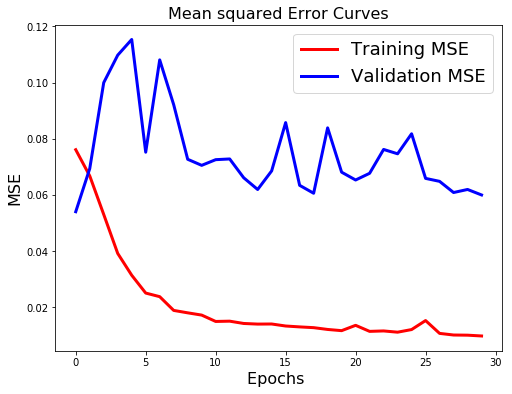

In [39]:
#Plot the Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training MSE', 'Validation MSE'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('MSE',fontsize=16)
plt.title('Mean squared Error Curves',fontsize=16)


## Conlusions:

In [40]:
#reporting the results in a table
t= PrettyTable()
t.field_names =["metric/Parameter" , "result"]
t.add_row (["Model" ,"Base-line"])
t.add_row (["MSE" ,0.241561])
print(t)


t= PrettyTable()
t.field_names =["metric/Parameter" , "result"]
t.add_row (["Model" ,"CNN-TensorFlow"])
t.add_row (["dropout" ,0.5])
t.add_row (["final-layer" ,"linear"])
t.add_row (["optimizer" ,"adam"])
t.add_row (["learning_rate" ,0.001])
t.add_row (["MSE" ,1.50731])
print(t)



t= PrettyTable()
t.field_names =["metric/Parameter" , "result"]
t.add_row (["Model" ,"CNN-Keras"])
t.add_row (["dropout" ,0.5])
t.add_row (["final-layer" ,"atan"])
t.add_row (["optimizer" ,"adam"])
t.add_row (["learning_rate" ,0.001])
t.add_row (["MSE" , 0.0600
])
print(t)

+------------------+-----------+
| metric/Parameter |   result  |
+------------------+-----------+
|      Model       | Base-line |
|       MSE        |  0.241561 |
+------------------+-----------+
+------------------+----------------+
| metric/Parameter |     result     |
+------------------+----------------+
|      Model       | CNN-TensorFlow |
|     dropout      |      0.5       |
|   final-layer    |     linear     |
|    optimizer     |      adam      |
|  learning_rate   |     0.001      |
|       MSE        |    1.50731     |
+------------------+----------------+
+------------------+-----------+
| metric/Parameter |   result  |
+------------------+-----------+
|      Model       | CNN-Keras |
|     dropout      |    0.5    |
|   final-layer    |    atan   |
|    optimizer     |    adam   |
|  learning_rate   |   0.001   |
|       MSE        |    0.06   |
+------------------+-----------+
